<a href="https://colab.research.google.com/github/JD39/Processing-of-precipitation-data-over-Rio-Negro-basin/blob/main/red_neuronal_rio_negro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Red neuronal MPL para estimar el nivel a corto plazo del Rio Negro - Uruguay**

Este algoritmo basado en una red neuronal perceptron multicapa (MPL) tiene como variables de entrada la serie de tiempo de la precipitación y el nivel tomado de 18 estaciones hidrometricás de la cuenca del Rio Negro y tiene como salida la variable nivel en la estación mas baja con un dia de anticipación. 

In [ ]:
#Libreria para el manejo de datos y machine learning
from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten
from keras.models import Sequential
from keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras import backend as K

import tensorflow as tf
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import datetime
from numpy.random import seed
from time import time

seed_number = 38
seed(seed_number)
tf.random.set_seed(seed_number)
np.random.seed(seed_number)

Funciones para testear el rendimiento del modelo hidrologico empirico basado en la red neuronal

In [ ]:

def get_max_nse(history):
    validation = history.history["val_nse"]
    ymax = max(validation)
    return "Max NSE ≈ " + "%.6f" % ymax

def get_metrics(history):
    validation_rmse = history.history["val_rmse"]
    validation_nse = history.history["val_nse"]
    return min(validation_rmse), max(validation_nse) 

def plot_history(history, title):
  fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 6))

  fig.suptitle(title)
 
  ax1.plot(history.history['nse'], label='train')
  ax1.plot(history.history['val_nse'], label='test')
  ax1.set_ylabel('nse')
  ax1.set_xlabel('epoch')

  ax2.plot(history.history['loss'], label='train')
  ax2.plot(history.history['val_loss'], label='test')
  ax2.set_ylabel('loss')
  ax2.set_xlabel('epoch')
  
  ax1.text(
        0.97,
        0.97,
        get_max_nse(history),
        horizontalalignment="right",
        verticalalignment="top",
        transform=ax1.transAxes,
        fontsize=18,
    )
  plt.legend()
  plt.show()

Cargamos el data set de lluvia y nivel de las estaciones

In [ ]:
cd'/content/drive/MyDrive/PhD/CAP-425-2021'

/content/drive/MyDrive/PhD/CAP-425-2021


In [ ]:
df = pd.read_csv('nivel_precipitation_data.csv')
df.describe()

,Manuel_Diaz_precipitation,Manuel_Diaz_level,Cuñapirú_precipitation,Cuñapirú_level,Coelho_precipitation,Coelho_level,Paso_de_las_Toscas_precipitation,Paso_de_las_Toscas_level,Laguna_I_precipitation,Laguna_I_level,Laguna_II_precipitation,Laguna_II_level,Mazagano_precipitation,Mazagano_level,Aguiar_precipitation,Aguiar_level,Pereira_precipitation,Pereira_level,San_Gregorio_precipitation,San_Gregorio_level,Bonete_precipitation,Bonete_level,Paso_de_los_toros_precipitation,Paso_de_los_toros_level,Salsipuedes_precipitation,Salsipuedes_level,Sarandi_del_Yi_precipitation,Sarandi_del_Yi_level,Polanco_precipitation,Polanco_level,Durazno_precipitation,Durazno_level,Paso_de_Lugo_precipitation,Paso_de_Lugo_level,Mercedes_precipitation,Mercedes_level,Villa_Soriano_precipitation,Villa_Soriano_level
count,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000
mean,4.335007,1.992980,4.008101,1.382445,3.763008,2.901822,3.543359,1.238522,3.331698,3.747264,4.485851,4.090307,3.576906,2.718458,3.694204,3.588133,4.121406,3.708582,4.188156,8.687344,3.654496,78.502173,3.726495,7.989142,3.174692,1.882088,3.563213,1.548245,3.445459,2.858203,3.442150,1.470832,3.173437,1.835632,3.153355,2.023464,3.063555,1.684979
std,12.842213,1.863693,11.838350,0.993373,11.453881,1.483205,10.944797,0.785951,11.318528,2.297602,14.837153,2.015235,11.064948,2.043718,10.802510,2.203403,13.391464,2.095466,12.546434,2.347338,11.956990,2.358241,11.996224,0.681689,10.530545,0.758414,12.011227,0.852245,11.923524,1.737467,11.877211,2.132054,11.166623,1.141513,10.234744,1.265877,10.021956,0.578388
min,0.000000,0.010000,0.000000,0.380000,0.000000,1.280000,0.000000,0.180000,0.000000,1.310000,0.000000,1.340000,0.000000,0.570000,0.000000,1.050000,0.000000,1.220000,0.000000,3.100000,0.000000,72.890000,0.000000,7.000000,0.000000,0.240000,0.000000,0.060000,0.000000,1.160000,0.000000,0.000000,0.000000,0.540000,0.000000,0.000000,0.000000,0.390000
25%,0.000000,0.610000,0.000000,0.760000,0.000000,1.640000,0.000000,0.570000,0.000000,1.820000,0.000000,2.530000,0.000000,1.080000,0.000000,1.783750,0.000000,1.980000,0.000000,6.775000,0.000000,76.610000,0.000000,7.600000,0.000000,1.520000,0.000000,1.120000,0.000000,1.620000,0.000000,0.000000,0.000000,1.220000,0.000000,1.250000,0.000000,1.300000
50%,0.000000,1.210000,0.000000,1.010000,0.000000,2.270000,0.000000,1.090000,0.000000,2.970000,0.000000,3.710000,0.000000,1.730000,0.000000,2.660000,0.000000,2.990000,0.000000,9.700000,0.000000,79.540000,0.000000,7.800000,0.000000,1.720000,0.000000,1.237500,0.000000,2.230000,0.000000,0.520000,0.000000,1.520000,0.000000,1.700000,0.000000,1.620000
75%,0.000000,3.015000,0.000000,1.620000,0.000000,4.095000,0.000000,1.695000,0.000000,5.130000,0.000000,5.260000,0.000000,4.050000,0.500000,5.195000,0.000000,5.195000,0.000000,10.310000,0.000000,80.150000,0.000000,8.090000,0.000000,1.970000,0.000000,1.530000,0.000000,3.415000,0.000000,1.845000,0.000000,1.940000,0.000000,2.300000,0.000000,2.000000
max,125.000000,9.390000,116.000000,6.720000,113.000000,6.600000,116.000000,4.980000,130.000000,12.100000,221.000000,11.590000,115.000000,8.240000,111.000000,9.370000,177.000000,10.150000,128.000000,13.160000,160.000000,82.870000,160.000000,12.300000,156.000000,10.280000,158.000000,7.120000,150.000000,12.990000,197.000000,12.100000,152.000000,11.700000,125.000000,8.400000,110.000000,4.400000


In [ ]:
data=df
#data=df.drop(['Sarandi_del_Yi_level', 'Sarandi_del_Yi_precipitation' ''], axis=1)
#data.describe()

In [ ]:
# convert column to datetime pandas
data['dt'] = pd.to_datetime(data['dt'])

**Graficar por estación**

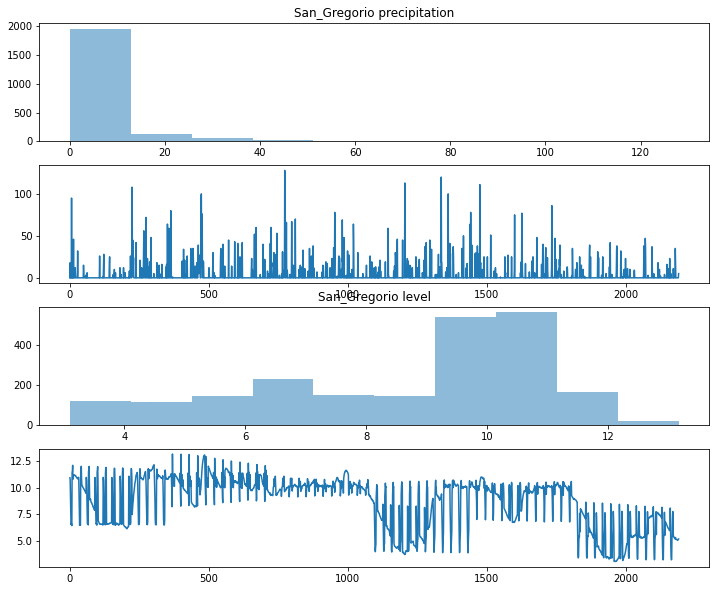

In [ ]:
plt.figure(figsize=(12,10))
plt.subplot(4, 1, 1)
plt.hist(df['San_Gregorio_precipitation'], bins=10, alpha=0.5)
plt.title("San_Gregorio precipitation")

plt.subplot(4, 1, 2)
plt.plot(df['San_Gregorio_precipitation'])
#plt.title("Sarandi_del_Yi precipitation")

plt.subplot(4, 1, 3)
plt.hist(df['San_Gregorio_level'], bins=10, alpha=0.5)
plt.title("San_Gregorio level")

plt.subplot(4, 1, 4)
plt.plot(df['San_Gregorio_level'])
#plt.title("Sarandi_del_Yi level")
# Mostrar
plt.show()

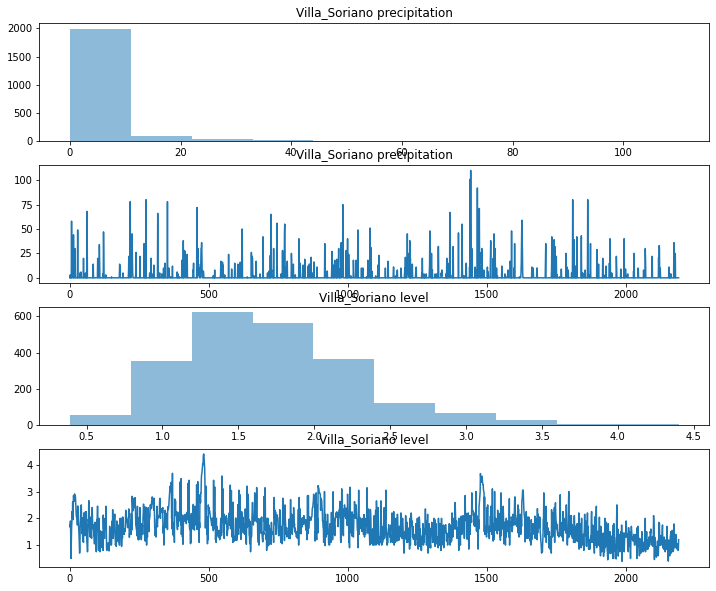

In [ ]:
plt.figure(figsize=(12,10))
plt.subplot(4, 1, 1)
plt.hist(df['Villa_Soriano_precipitation'], bins=10, alpha=0.5)
plt.title("Villa_Soriano precipitation")

plt.subplot(4, 1, 2)
plt.plot(df['Villa_Soriano_precipitation'])
plt.title("Villa_Soriano precipitation")

plt.subplot(4, 1, 3)
plt.hist(df['Villa_Soriano_level'], bins=10, alpha=0.5)
plt.title("Villa_Soriano level")

plt.subplot(4, 1, 4)
plt.plot(df['Villa_Soriano_level'])
plt.title("Villa_Soriano level")
# Mostrar
plt.show()

In [ ]:
# data.plot(y=[ 'Villa_Soriano_precipitation'],marker = 'o', figsize=(15,10)) #kind="bar", linestyle='dashed'
# plt.title('Rainfall gauge data ', family='serif', color='black', weight='normal', size = 18)
# plt.ylabel('Precipitation[mm/hr]', family='serif', color='black', weight='normal', size = 16, labelpad = 6)
# plt.xlabel('time', family='serif', color='black', weight='normal', size = 16, labelpad = 6)
 

In [ ]:
#  data.plot( y=['Villa_Soriano_level' ],linestyle='dashed', figsize=(15,10)) #kind="bar",
#  plt.title('Water level ', family='serif', color='black', weight='normal', size = 18)
#  plt.ylabel('Water level [m]', family='serif', color='black', weight='normal', size = 16, labelpad = 6)
#  plt.xlabel('time', family='serif', color='black', weight='normal', size = 16, labelpad = 6)

In [ ]:
data=data.set_index('dt')

In [ ]:
data.index = pd.to_datetime(data.index)

In [ ]:
data

,Manuel_Diaz_precipitation,Manuel_Diaz_level,Cuñapirú_precipitation,Cuñapirú_level,Coelho_precipitation,Coelho_level,Paso_de_las_Toscas_precipitation,Paso_de_las_Toscas_level,Laguna_I_precipitation,Laguna_I_level,Laguna_II_precipitation,Laguna_II_level,Mazagano_precipitation,Mazagano_level,Aguiar_precipitation,Aguiar_level,Pereira_precipitation,Pereira_level,San_Gregorio_precipitation,San_Gregorio_level,Bonete_precipitation,Bonete_level,Paso_de_los_toros_precipitation,Paso_de_los_toros_level,Salsipuedes_precipitation,Salsipuedes_level,Sarandi_del_Yi_precipitation,Sarandi_del_Yi_level,Polanco_precipitation,Polanco_level,Durazno_precipitation,Durazno_level,Paso_de_Lugo_precipitation,Paso_de_Lugo_level,Mercedes_precipitation,Mercedes_level,Villa_Soriano_precipitation,Villa_Soriano_level
dt,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-01 07:00:00,0.0,5.8300,0.0,2.36,0.0,3.05,0.0,0.89,0.0,4.96,0.0,5.08,0.0,4.25,0.0,4.45,0.0,4.06,0.0,10.93,0.0,80.74,0.0,8.07,1.0,1.98,0.0,1.3175,0.0,3.3525,0.0,0.36,0.0,2.0400,0.0,1.85,0.0,1.75
2015-02-01 07:00:00,20.0,1.3900,20.0,0.93,18.0,2.21,24.0,0.79,5.0,3.05,10.0,4.24,20.0,1.83,13.0,2.56,20.0,2.64,18.0,10.78,21.0,80.59,17.0,7.90,5.0,1.83,10.0,1.6025,10.0,2.2975,1.0,0.87,11.0,2.9600,8.0,1.65,3.0,1.67
2015-03-01 07:00:00,0.0,2.3700,0.0,1.01,0.0,1.90,0.0,0.51,0.0,1.83,0.0,2.84,0.0,1.39,0.0,2.15,0.0,1.96,0.0,9.40,0.0,79.30,0.0,7.70,0.0,1.55,0.0,1.1150,0.0,1.6875,0.0,0.00,0.0,1.5300,0.0,1.70,0.0,1.90
2015-04-01 07:00:00,0.0,0.4400,0.0,0.70,0.0,1.45,0.0,0.38,0.0,1.51,0.0,1.74,0.0,0.87,0.0,1.41,0.0,1.60,0.0,7.80,0.0,77.56,0.0,8.05,0.0,1.90,0.0,1.0950,0.0,1.5800,0.0,0.00,0.0,1.2600,0.0,0.60,0.0,1.36
2015-05-01 07:00:00,0.0,0.3100,0.0,0.64,0.0,1.30,0.0,0.33,0.0,1.38,0.0,1.53,0.0,0.67,0.0,1.06,0.0,1.40,0.0,6.56,0.0,76.38,0.0,7.60,0.0,1.51,0.0,0.5100,0.0,1.3900,0.0,0.00,0.0,1.2000,0.0,0.10,0.0,0.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-05-12 07:00:00,0.0,0.1825,0.0,0.62,0.0,1.31,0.0,0.32,0.0,1.48,0.0,1.52,0.0,0.76,0.0,1.10,0.0,1.26,0.0,5.15,0.0,74.92,0.0,7.62,0.0,1.57,0.0,1.0700,0.0,1.3000,0.0,0.00,0.0,0.8200,0.0,0.65,0.0,1.03
2018-06-12 07:00:00,0.0,0.1825,0.0,0.60,0.0,1.30,0.0,0.31,0.0,1.45,0.0,1.50,0.0,0.78,0.0,1.10,0.0,1.25,0.0,5.11,0.0,74.96,0.0,7.60,0.0,1.55,0.0,1.0700,0.0,1.2900,0.0,0.00,0.0,0.8200,0.0,0.80,0.0,1.05
2018-07-12 07:00:00,0.0,0.1825,0.0,0.58,0.0,1.29,0.0,0.30,0.0,1.44,0.0,1.48,0.0,0.73,0.0,1.11,0.0,1.24,0.0,5.13,0.0,74.92,0.0,7.61,0.0,1.55,0.0,1.0700,0.0,1.2800,0.0,0.00,0.0,0.8325,0.0,1.00,0.0,0.80


Normalizamos los datos y sepramos en el conjunto de entrada 

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
# Considera como entrada los datos de precipitación y nivel de todas las estaciones para el tiempo t
x = scaler.fit_transform(data[[ 
          'Manuel_Diaz_precipitation','Manuel_Diaz_level',
          'Cuñapirú_precipitation', 'Cuñapirú_level',                              
          'Coelho_precipitation','Coelho_level',          
          'Paso_de_las_Toscas_precipitation','Paso_de_las_Toscas_level',           
          'Laguna_I_precipitation', 'Laguna_I_level', 
          'Laguna_II_precipitation','Laguna_II_level', 
          'Mazagano_level', 'Mazagano_precipitation',
          'Aguiar_precipitation', 'Aguiar_level',
          'Pereira_level', 'Pereira_precipitation',
          'San_Gregorio_level', 'San_Gregorio_precipitation', 
          'Bonete_level', 'Bonete_precipitation',
          'Paso_de_los_toros_precipitation', 'Paso_de_los_toros_level', 
          'Salsipuedes_level', 	'Salsipuedes_precipitation', 
          'Sarandi_del_Yi_level',	'Sarandi_del_Yi_precipitation',	
          'Polanco_level', 	'Polanco_precipitation',
          'Durazno_precipitation', 'Durazno_level',                                                      
          'Paso_de_Lugo_precipitation','Paso_de_Lugo_level',                    
          'Mercedes_precipitation', 'Mercedes_level', 
          'Villa_Soriano_precipitation','Villa_Soriano_level' ]].values)

#Considera como salida los datos de nivel para la estacion de Villa Soriano para el tiempo t + 1
#y = x[:,1::2]
y = x[:,37]
date_split = pd.to_datetime(datetime.datetime(year=2019, month=7, day=1, hour=7, minute=0))
train_index = data.loc[data.index<date_split]

i = 1

## Remove o ultimo tempo do df de x e o primeiro do df de y
in_data = x[:]
out_data = y[:]
#in_data = x[:-i]
#out_data = y[i:]

print(in_data.shape)
print(out_data.shape)

#Split train and test data
x_train_without_test = in_data[0:train_index.shape[0],]
y_train_without_test = out_data[0:train_index.shape[0],]

x_test = in_data[train_index.shape[0]:,]
y_test = out_data[train_index.shape[0]:,]

x_train, x_val, y_train, y_val = train_test_split(x_train_without_test, y_train_without_test,
                                                  test_size=0.2, random_state=seed_number)


(2191, 38)
(2191,)


In [ ]:
#x_train.shape

In [ ]:
#len(y_train_without_test )

In [ ]:
#date_split

In [ ]:
#data.index

In [ ]:
def nse(y_true, y_pred):
	return 1 - (K.sum((y_pred - y_true)**2)/
                         K.sum((y_true - K.mean(y_true))**2)) 

def rmse(y_true, y_pred):
	return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 

Definimos la red neuronal

In [ ]:
input_dim = x_train.shape[1]

model = Sequential()

model.add(Dense(15,input_shape=(input_dim,),activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(optimizer='adam', loss='mean_absolute_error', metrics=[rmse, nse])
model.summary()

history = model.fit(x_train, y_train, epochs=100, batch_size=500,
                        validation_data=(x_val, y_val))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 15)                585       
                                                                 
 dense_1 (Dense)             (None, 1)                 16        
                                                                 
Total params: 601
Trainable params: 601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
3/3 [==============================] - 1s 112ms/step - loss: 0.2329 - rmse: 0.2329 - nse: -2.9876 - val_loss: 0.1864 - val_rmse: 0.1864 - val_nse: -2.2723
Epoch 2/100
3/3 [==============================] - 0s 15ms/step - loss: 0.2001 - rmse: 0.2001 - nse: -2.0727 - val_loss: 0.1620 - val_rmse: 0.1620 - val_nse: -1.5241
Epoch 3/100
3/3 [==============================] - 0s 16ms/step - loss: 0.1724 - rmse: 0.1724 - nse: -1.3449 - val_loss: 

(0.015489757992327213, 0.9751335978507996)


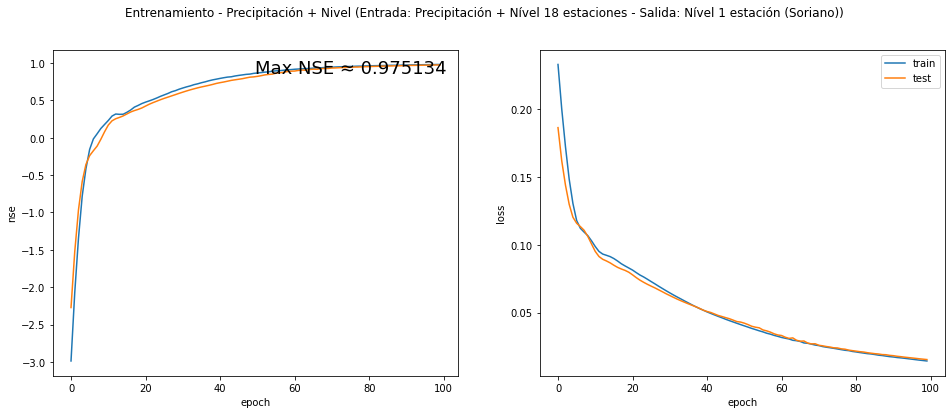

In [ ]:
print(get_metrics(history))
plot_history(history, 'Entrenamiento - Precipitación + Nivel (Entrada: Precipitación + Nível 18 estaciones - Salida: Nível 1 estación (Soriano))')

(444, 38) (444, 38)
444


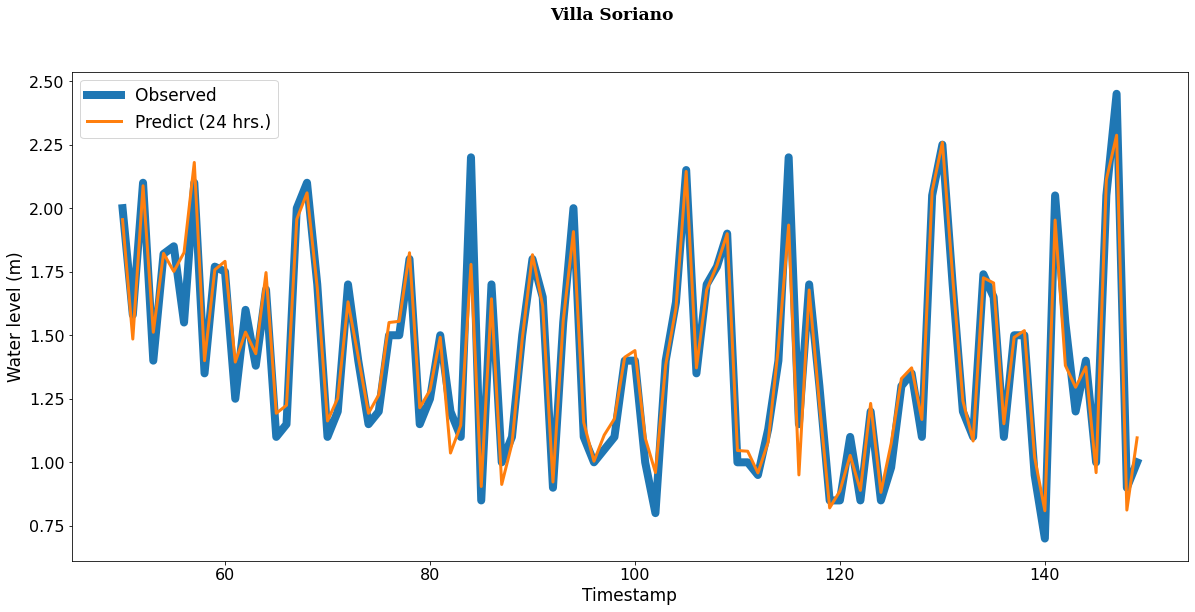

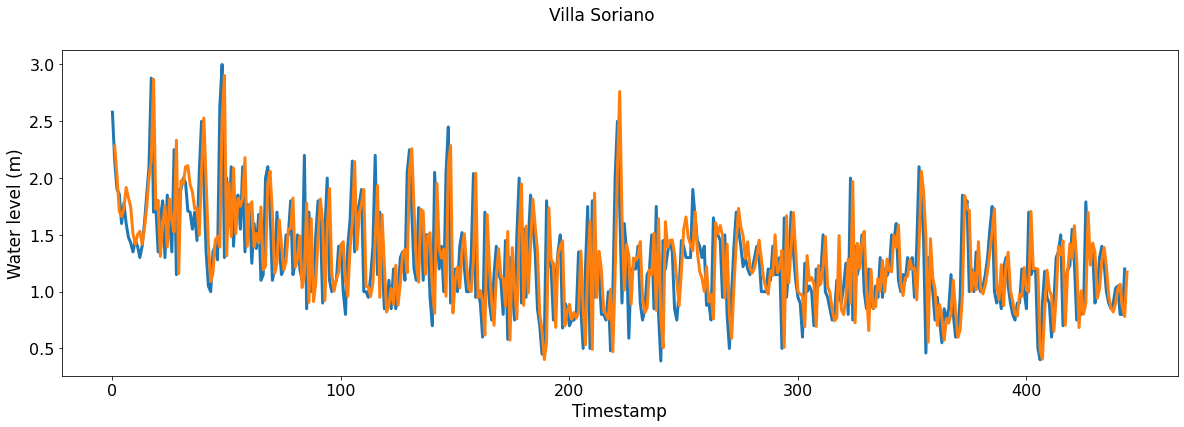

In [ ]:
predict_values = model.predict(x_test)

predict_dataset = np.zeros(shape=(len(predict_values), 38))
predict_dataset[:,37] = predict_values.reshape(1,len(predict_values))
predict_dataset = scaler.inverse_transform(predict_dataset)
#predict_dataset=predict_dataset.reshape(len(predict_values), 38)

test_dataset = np.zeros(shape=(len(y_test), 38))
test_dataset[:,37] = y_test
test_dataset = scaler.inverse_transform(test_dataset)

print(predict_dataset.shape, test_dataset.shape)


n_size = 100
total_size = predict_dataset.shape[0]
print(total_size)

start = 50

fig, (ax1) = plt.subplots(1,1, figsize=(20, 9))
plt.plot(range(start,n_size+start), test_dataset[:,37][start:n_size+start], label='Observed', linewidth=8.0)
plt.plot(range(start,n_size+start), predict_dataset[:,37][start:(n_size+start)], label='Predict ('+ str(i*24) + ' hrs.)', linewidth=3.0)
plt.legend(fontsize=17)
plt.tick_params(labelsize=16)
plt.suptitle('Villa Soriano', fontsize=17, family='serif', color='black', weight='bold')
ax1.set_ylabel('Water level (m)', fontsize=17)
ax1.set_xlabel('Timestamp',fontsize=17)

plt.show()


fig2, (ax1) = plt.subplots(1,1, figsize=(20, 6))
plt.plot(range(total_size), test_dataset[:,37][:total_size], label='Observed', linewidth=3.0)
plt.plot(range(i,total_size+i), predict_dataset[:,37][:total_size], label='Predict (24 hrs.)', linewidth=3.0)
plt.tick_params(labelsize=16)
plt.suptitle('Villa Soriano', fontsize=17)
ax1.set_ylabel('Water level (m)', fontsize=17)
ax1.set_xlabel('Timestamp',fontsize=17)

plt.show()



In [ ]:
#len(test_dataset)

slope: 0.961796    intercept: 0.067170
R-squared: 0.956993


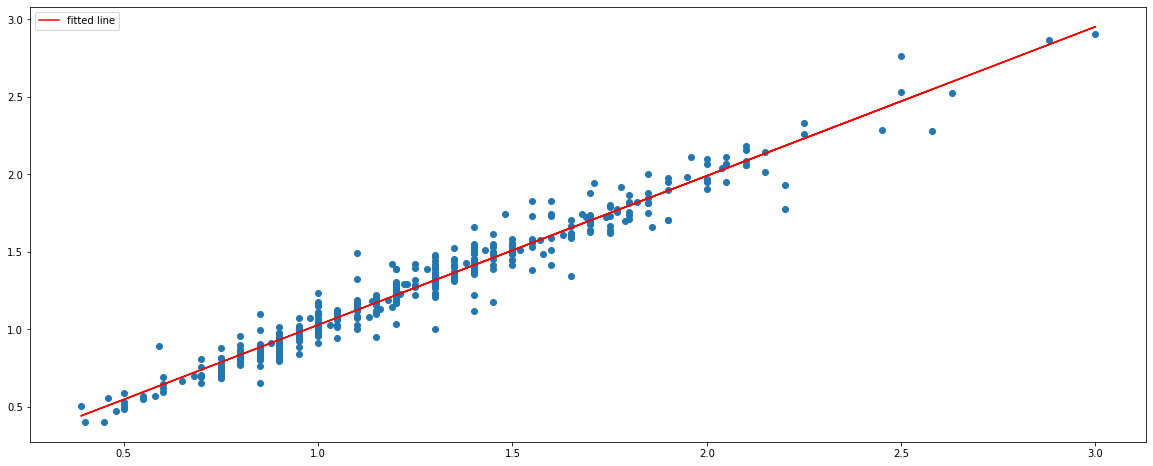

Correlación
0.97826001250688


In [ ]:
x1 = test_dataset[:,37][:total_size]
y1 = predict_dataset[:,37][:total_size]
slope, intercept, r_value, p_value, std_err = stats.linregress(x1, y1)
print("slope: %f    intercept: %f" % (slope, intercept))
print("R-squared: %f" % r_value**2)

# plot 
f2, ax2 = plt.subplots(figsize=(20,8))
plt.scatter(x1,y1)
plt.plot(x1, intercept + slope*x1, 'r', label='fitted line', markersize=12)
plt.legend()
plt.show()
corr = np.corrcoef(x1,y1)
corr = corr[0,1]
print('Correlación')
print(corr)